In [1]:
%pwd

'/qbio/yoojung/coursework/2021-1/bioinfo1/bioinfo-term-project/notebooks'

In [2]:
# download Ensembl-GO term mapped info from Uniprot
%cd ../data/
!wget https://www.uniprot.org/uniprot/?query=mus+musculus&sort=score#

/qbio/yoojung/coursework/2021-1/bioinfo1/bioinfo-term-project/data


In [3]:
%cd ../notebooks/

/qbio/yoojung/coursework/2021-1/bioinfo1/bioinfo-term-project/notebooks


In [4]:
# load dataset as dataframe
import numpy as np
import pandas as pd

ENSID_GO = pd.read_csv('../data/uniprot-mus+musculus.tab', sep='\t')
print(ENSID_GO.shape)

(115264, 5)


In [5]:
# filtering not Mus musculus or NaN values
ENSID_GO.drop(ENSID_GO.loc[ENSID_GO['Organism']!='Mus musculus (Mouse)'].index, inplace=True)
ENSID_GO.dropna(axis=0, inplace=True)
ENSID_GO = ENSID_GO.reset_index(drop=True)
print(ENSID_GO.shape)
ENSID_GO.head()

(33155, 5)


,Entry,Gene names,Organism,Ensembl transcript,Gene ontology (cellular component)
0,P02762,Mup6,Mus musculus (Mouse),ENSMUST00000080606;ENSMUST00000095051;ENSMUST0...,cytosol [GO:0005829]; extracellular space [GO:...
1,Q91ZJ0,Mus81,Mus musculus (Mouse),ENSMUST00000124334;,Holliday junction resolvase complex [GO:004847...
2,Q8R4K8,Pappa,Mus musculus (Mouse),ENSMUST00000084501 [Q8R4K8-1];,extracellular region [GO:0005576]; extracellul...
3,P01887,B2m,Mus musculus (Mouse),ENSMUST00000102476;,cytosol [GO:0005829]; external side of plasma ...
4,O89116,Vti1a Vti1 Vti1l2,Mus musculus (Mouse),ENSMUST00000095950;,autophagosome [GO:0005776]; clathrin-coated ve...


In [6]:
# make a dictionary of ensembl transcript ID - gene ID matches
import re

ensembl_ID = {}

transcriptID_pat = re.compile('ENSMUST[0-9]*')
geneID_pat = re.compile('ENSMUSG[0-9]*')

with open('../../binfo1-datapack1/gencode.gtf') as gtffile:
    for line in gtffile:
        if line.startswith('#'):
            continue
        elif line.split('\t')[2] == 'transcript':
            transcriptID = transcriptID_pat.findall(line)[0]
            geneID = geneID_pat.findall(line)[0]
            ensembl_ID[transcriptID] = geneID

In [7]:
# add 'Ensembl gene' column to ENSID_GO(dataframe)

geneID_sets = []

for i in range(len(ENSID_GO)):
    geneID_set = set()
    for transcriptID in transcriptID_pat.findall(ENSID_GO.loc[i]['Ensembl transcript']):
        if transcriptID in ensembl_ID.keys():
            geneID_set.add(ensembl_ID[transcriptID])
    geneID_sets.append(';'.join(geneID_set))

ENSID_GO['Ensembl gene'] = geneID_sets

In [8]:
# get all of GO IDs

GOterm_li = [cc.split('; ') for cc in ENSID_GO['Gene ontology (cellular component)'].tolist()]

GOterms = []

for li in GOterm_li:
    for GO in li:
        GOterms.append(GO)
        
GOterms = list(set(GOterms))

In [9]:
# extract only GO IDs and specifications
GO_ID = []
GO_spec = []

GO_ID_pat = re.compile('GO:[0-9]*')

for GO in GOterms:
    GO_ID.append(GO_ID_pat.findall(GO)[0])
    GO_spec.append(GO[:-13])

In [10]:
GO_term_df = pd.DataFrame([GO_ID, GO_spec], index=['GO_id', 'specifications']).T
GO_term_df

,GO_id,specifications
0,GO:0120003,hinge region between urothelial plaques of api...
1,GO:0002193,MAML1-RBP-Jkappa- ICN1 complex
2,GO:0045259,proton-transporting ATP synthase complex
3,GO:0070033,synaptobrevin 2-SNAP-25-syntaxin-1a-complexin ...
4,GO:0140268,endoplasmic reticulum-plasma membrane contact ...
...,...,...
1745,GO:0097729,9+2 motile cilium
1746,GO:0033291,eukaryotic 80S initiation complex
1747,GO:1990590,ATF1-ATF4 transcription factor complex
1748,GO:0034998,oligosaccharyltransferase I complex


In [11]:
ENSID_GO['GO_id'] = ''

for i in range(len(ENSID_GO)):
    GO_ids = GO_ID_pat.findall(ENSID_GO.loc[i]['Gene ontology (cellular component)'])
    ENSID_GO.loc[i]['GO_id'] = ';'.join(GO_ids)

In [12]:
cnts = pd.read_csv('../data/read-counts.txt', sep='\t', comment='#')
cnts.head()

,Geneid,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam
0,ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0
1,ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0
2,ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;349192...,3277540;3277540;3285855;3286567;3287191;349212...,-;-;-;-;-;-;-,6094,4,1,1,1,0,0
3,ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,3,0,0,0,0,0
4,ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0


In [13]:
ENSG_GO_dict = {}

for i in range(len(ENSID_GO)):
    if len(str(ENSID_GO.loc[i]['Ensembl gene']).split(';')) != 1:
        for key in str(ENSID_GO.loc[i]['Ensembl gene']).split(';'):
            ENSG_GO_dict[key] = str(ENSID_GO.loc[i]['GO_id'])
    else:
        key = str(ENSID_GO.loc[i]['Ensembl gene'])[:-1]
        ENSG_GO_dict[key] = str(ENSID_GO.loc[i]['GO_id'])

In [14]:
bamgene_GO_dict = {}

for i in range(len(cnts)):
    geneID = cnts.loc[i]['Geneid'][:-2]
    if geneID in ENSG_GO_dict.keys():
        GOterm = ENSG_GO_dict[geneID]
        bamgene_GO_dict[geneID] = GOterm

In [15]:
GO_bamgene_dict = {}

for k, v in bamgene_GO_dict.items():
    GOterms = v.split(';')
    for GO in GOterms:
        if GO in GO_bamgene_dict.keys():
            GO_bamgene_dict[GO] = GO_bamgene_dict[GO] + ';' + k
        else:
            GO_bamgene_dict[GO] = k

In [16]:
GOid_ENSGid_mapped = pd.DataFrame({'GO_id':[k for k in GO_bamgene_dict.keys()], 'ENSG_id':[v for v in GO_bamgene_dict.values()]})
mapped_GO_ENSG = pd.merge(GO_term_df, GOid_ENSGid_mapped)

In [17]:
mapped_GO_ENSG['gene_num'] = mapped_GO_ENSG['ENSG_id'].apply(lambda x: x.count('ENSMUSG'))

In [18]:
counts_per_gene = {}

for i in range(len(cnts)):
    key = cnts.loc[i]['Geneid'][:-2]
    counts_per_gene[key] = [cnts.iloc[i][6], cnts.iloc[i][7], cnts.iloc[i][8], cnts.iloc[i][9], cnts.iloc[i][10], cnts.iloc[i][11]]

In [19]:
from scipy import stats
import random

In [20]:
def calc_pval(counts):
    if sum(counts)==0:
        p_val = 1
    else:
        if len(counts)%2 == 0:
            length = len(counts)
        else:
            length = len(counts) + 1
        set1, set2 = counts[:int(length/2)], counts[int(length/2):]
        p_val = stats.mannwhitneyu(set1, set2)[1]
        
        return p_val

In [21]:
counts_set = []
clip_enrichment = []
rden_change = []
CE_p_vals = []
RC_p_vals = []

for i in range(len(mapped_GO_ENSG)):
    genes = mapped_GO_ENSG.loc[i]['ENSG_id'].split(';')
    counts = np.array([0,0,0,0,0,0])
    CEs_gene, RCs_gene = [], []
    
    for gene in genes:
        counts_gene = counts_per_gene[gene]
        CE_gene = np.log2((counts_gene[0]+0.1) / (counts_gene[1]+0.1))
        RC_gene = np.log2(((counts_gene[4]+1) / (counts_gene[2]+1)) / ((counts_gene[5]+1) / (counts_gene[3]+1)))
        CEs_gene.append(CE_gene)
        RCs_gene.append(RC_gene)
        counts += np.array(counts_per_gene[gene])
        
    counts_set.append(counts)
    
    CE = np.log2((counts[0]+1) / (counts[1]+1))
    RC = np.log2(((counts[4]+1) / (counts[2]+1)) / ((counts[5]+1) / (counts[3]+1)))
    
    random.shuffle(CEs_gene)
    random.shuffle(RCs_gene)
    
    if len(genes) == 1:
        CE_p_val = 1
        RC_p_val = 1
    else:
        CE_p_val = calc_pval(CEs_gene)
        RC_p_val = calc_pval(RCs_gene)

    clip_enrichment.append(CE)
    rden_change.append(RC)
    CE_p_vals.append(CE_p_val)
    RC_p_vals.append(RC_p_val)

In [22]:
counts_col = pd.Series(counts_set, name='counts')
CE_col = pd.Series(clip_enrichment, name='clip enrichment')
RC_col = pd.Series(rden_change, name='rden change')
CE_p_val_col = pd.Series(CE_p_vals, name='p-value(clip enrichment)')
RC_p_val_col = pd.Series(RC_p_vals, name='p-value(rden change)')
mapped_GO_ENSG = pd.concat([mapped_GO_ENSG, counts_col, CE_col, RC_col, CE_p_val_col, RC_p_val_col], axis=1)
mapped_GO_ENSG

,GO_id,specifications,ENSG_id,gene_num,counts,clip enrichment,rden change,p-value(clip enrichment),p-value(rden change)
0,GO:0000421,autophagosome membrane,ENSMUSG00000095463,1,"[155, 43, 275, 221, 111, 65]",1.825971,0.448852,1.000000,1.000000
1,GO:0005730,nucleolus,ENSMUSG00000067925;ENSMUSG00000067924,2,"[0, 18, 18, 15, 2, 7]",-4.247928,-1.662965,0.500000,0.500000
2,GO:0000786,nucleosome,ENSMUSG00000081058;ENSMUSG00000063954;ENSMUSG0...,54,"[9495, 402, 1042, 931, 127221, 176435]",4.558468,-0.634134,0.299921,0.479159
3,GO:0098685,Schaffer collateral - CA1 synapse,ENSMUSG00000101645,1,"[0, 0, 0, 0, 0, 0]",0.000000,0.000000,1.000000,1.000000
4,GO:0005739,mitochondrion,ENSMUSG00000095143;ENSMUSG00000095388;ENSMUSG0...,11,"[238, 261, 436, 395, 77, 81]",-0.132556,-0.214283,0.227386,0.155431
...,...,...,...,...,...,...,...,...,...
175,GO:0044613,nuclear pore central transport channel,ENSMUSG00000008450;ENSMUSG00000071497,2,"[43, 237, 41, 37, 22, 33]",-2.435386,-0.708291,0.500000,0.500000
176,GO:0015629,actin cytoskeleton,ENSMUSG00000116048,1,"[0, 0, 0, 0, 0, 0]",0.000000,0.000000,1.000000,1.000000
177,GO:0034363,intermediate-density lipoprotein particle,ENSMUSG00000109350,1,"[0, 0, 0, 0, 0, 0]",0.000000,0.000000,1.000000,1.000000
178,GO:0005829,cytosol,ENSMUSG00000078193;ENSMUSG00000062997;ENSMUSG0...,61,"[4439, 4468, 5381, 3660, 33071, 43007]",-0.009392,-0.934899,0.426842,0.065491


In [23]:
mapped_GO_ENSG = mapped_GO_ENSG.sort_values(by=['p-value(clip enrichment)']).reset_index(drop=True)
mapped_GO_ENSG['FDR'] = mapped_GO_ENSG.index/len(mapped_GO_ENSG)*0.05

In [24]:
mapped_GO_ENSG = mapped_GO_ENSG[mapped_GO_ENSG['FDR'] < 0.05]

In [25]:
import matplotlib.pyplot as plt

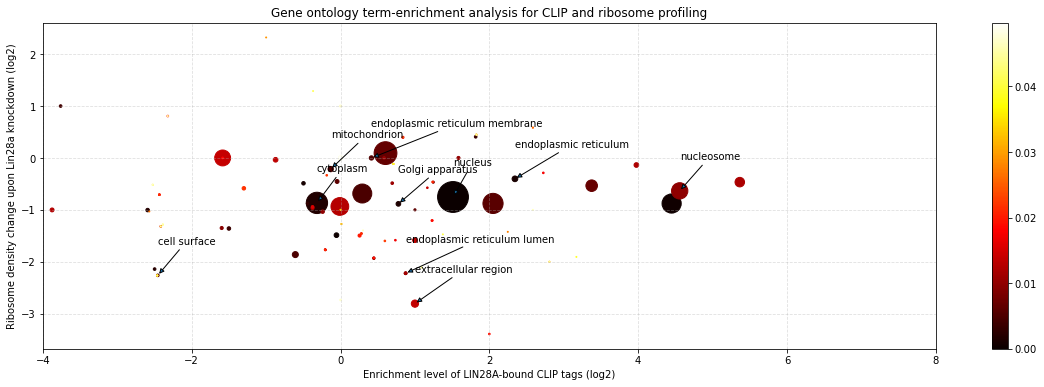

In [26]:
fig, ax = plt.subplots(1,1,figsize=(20,6))

s = ax.scatter(mapped_GO_ENSG['clip enrichment'].tolist(), mapped_GO_ENSG['rden change'].tolist(), s=mapped_GO_ENSG['gene_num']**1.4, c=mapped_GO_ENSG['FDR'], cmap='hot')
ax.set_xlim(-4,8)
# ax.set_ylim(-1, 1.5)
ax.set_xlabel('Enrichment level of LIN28A-bound CLIP tags (log2)')
ax.set_ylabel('Ribosome density change upon Lin28a knockdown (log2)')
ax.grid(linestyle='--', alpha=0.4)
ax.set_title('Gene ontology term-enrichment analysis for CLIP and ribosome profiling')

annotate_target = ['GO:0005783', 'GO:0005576', 'GO:0005789', 'GO:0009986', 'GO:0005788', 'GO:0000786', 'GO:0005739', 'GO:0005737', 'GO:0005634', 'GO:0005794']

for GO in annotate_target:
    index = mapped_GO_ENSG[mapped_GO_ENSG['GO_id'] == GO].index[0]
    spec = mapped_GO_ENSG.loc[index]['specifications']
    ax.annotate("{}".format(spec),
                xy=(mapped_GO_ENSG.loc[index]['clip enrichment'], mapped_GO_ENSG.loc[index]['rden change']),
                xytext=(mapped_GO_ENSG.loc[index]['clip enrichment'], mapped_GO_ENSG.loc[index]['rden change']+0.6),
                size=10,
                arrowprops=dict(arrowstyle="-|>"))

fig.colorbar(s, ax=ax)